In [1]:
import random
import numpy as np
# !pip install box2d-py
# !pip install gym
from unityagents import UnityEnvironment
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
from argparse import Namespace

args = Namespace(
    
    BUFFER_SIZE = int(1e5), # replay buffer size
    BATCH_SIZE = 256,        # minibatch size
    GAMMA = 0.99,           # discount factor
    TAU = 1e-3,             # for soft update of target parameters
    LR =  5e-4,             # learning rate
    UPDATE_EVERY = 16        # how often to update the network
)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DeepQNetwork(nn.Module):

    def __init__(self, input_dim, output_dim, fc1_units=64, fc2_units=64):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.A = nn.Linear(fc2_units, output_dim)
        self.V = nn.Linear(fc2_units, 1)
    
    def forward(self,x):
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        A = self.A(x)
        V = self.V(x)
        return V, A
        
        return x
        

class Agent:
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """
        Initialize an Agent object.
        
        :param state_size (int): dimension of each state
        :param action_size (int): dimension of each action
        :param seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.GAMMA = args.GAMMA
    
        # Deep Q-Network
        self.policy_network = DeepQNetwork(self.state_size, self.action_size).to(device)
        self.target_network = DeepQNetwork(self.state_size, self.action_size).to(device)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=args.LR)
        
        # Experience Replay Memory
        self.memory = ReplayBuffer(args.BUFFER_SIZE, args.BATCH_SIZE, seed)
        
        # Counter 
        self.t_step = 0
        
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add_experience(state, action, reward, next_state, done)
       
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % args.UPDATE_EVERY
        
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > args.BATCH_SIZE:
                experiences = self.memory.sample_experiences()
                self.learn(experiences)
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # put in network evaluation mode
        self.policy_network.eval()
        with torch.no_grad():
            _, advantage = self.policy_network(state)
        self.policy_network.train()
        
        #epsilon-greedy policy
        
        if random.random() > eps:
            return np.argmax(advantage.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))
    
    
    def learn(self, experiences):
        # Double-Q Learning
        
        states, actions, rewards, next_states, dones = experiences
        
        policy_V, policy_Adv = self.policy_network(states)
        target_V, target_Adv = self.target_network(next_states)

        Q_expected = torch.add(policy_V, (policy_Adv - policy_Adv.mean(dim=1, keepdim=True))).gather(1, actions)
        Q_target_next = torch.add(target_V, (target_Adv - target_Adv.mean(dim=1, keepdim=True))).max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states
        Q_targets = rewards + (self.GAMMA * Q_target_next * (1 - dones))
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.update_weights(self.policy_network, self.target_network, args.TAU)
        
        
    def update_weights(self, policy_network, target_network, tau):
        """Soft update model parameters.
        θ_target = τ*θ_policy + (1 - τ)*θ_target

        Params
        ======
            policy_network (PyTorch model): weights will be copied from
            target_network (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, policy_param in zip(target_network.parameters(), policy_network.parameters()):
            target_param.data.copy_(tau * policy_param.data + (1.0 - tau) * target_param.data)

        
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, seed):
        """
        :param buffer_size (int): size of experience replay memory/ buffer
        :param batch_size (int): batch size to sample from replay memory
        
        """
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=self.buffer_size)
        self.experience = namedtuple('experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
    
    def add_experience(self, state, action, reward, next_state, done):
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample_experiences(self):
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)


def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, mode=False):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores=[] # keep track of scores
    scores_window = deque(maxlen=100) # last 100 scores
    
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=mode)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.policy_network.state_dict(), 'DuelingDQN.pth')
            break

    return scores

In [3]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Episode 100	Average Score: 0.53
Episode 200	Average Score: 1.83
Episode 300	Average Score: 4.50
Episode 400	Average Score: 6.96
Episode 500	Average Score: 9.02
Episode 600	Average Score: 10.18
Episode 700	Average Score: 12.76
Episode 741	Average Score: 13.00
Environment solved in 641 episodes!	Average Score: 13.00


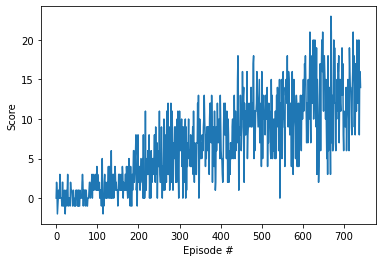

In [4]:
agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn(env, agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()